In [ ]:
6import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Model
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np

train_accuracy_history = []
validation_accuracy_history = []
train_loss_history = []
validation_loss_history = []

# Custom layer for dynamic feature selection
class FeatureSelectionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(FeatureSelectionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for each input feature
        self.feature_weights = self.add_weight(name='feature_weights',
                                               shape=(input_shape[1],),
                                               initializer='ones',
                                               trainable=True)
        super(FeatureSelectionLayer, self).build(input_shape)

    def call(self, x):
        # Apply feature selection based on learned weights with softmax activation
        weights = tf.nn.softmax(self.feature_weights)
        selected_features = x * tf.expand_dims(weights, axis=0)
        return selected_features

    def compute_output_shape(self, input_shape):
        return input_shape

def Fitness(feature_weights, data, model):
    h = data.sum(axis=1)

    # Regularization term to include the custom layer's weights in the loss
    regularization_term = tf.reduce_sum(feature_weights)

    # Add regularization term to the loss
    loss = 1 / (h.sum() + 0.01) + 0.001 * regularization_term

    return loss

# Load your dataset
df = pd.read_csv("/content/heartdataset.csv")
x = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Handle class imbalance using SMOTE (apply only on the training data)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)
oversample = SMOTE()
x_train, y_train = oversample.fit_resample(x_train, y_train)

# Standardize your input data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=13)  # You can adjust the number of components as needed
x_train_scaled_pca = pca.fit_transform(x_train_scaled)
x_test_scaled_pca = pca.transform(x_test_scaled)

# Reshape standardized input data for Conv1D
x_train_scaled_reshaped = tf.reshape(x_train_scaled_pca, [x_train_scaled_pca.shape[0], x_train_scaled_pca.shape[1], 1])
x_test_scaled_reshaped = tf.reshape(x_test_scaled_pca, [x_test_scaled_pca.shape[0], x_test_scaled_pca.shape[1], 1])

# Implement learning rate scheduling
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)

# Build the model with dynamic feature selection, batch normalization, and PCA
input_layer = Input(shape=(x_train_scaled_pca.shape[1], 1))
conv1 = Conv1D(64, 5, padding='same', activation='relu')(input_layer)
batch_norm1 = BatchNormalization()(conv1)
max_pool1 = MaxPooling1D(2)(batch_norm1)
conv2 = Conv1D(128, 5, padding='same', activation='relu')(max_pool1)
batch_norm2 = BatchNormalization()(conv2)
max_pool2 = MaxPooling1D(2)(batch_norm2)
conv3 = Conv1D(256, 5, padding='same', activation='relu')(max_pool2)
batch_norm3 = BatchNormalization()(conv3)
max_pool3 = MaxPooling1D(2)(batch_norm3)
dropout1 = Dropout(0.5)(max_pool3)
flatten = Flatten()(dropout1)
feature_selection = FeatureSelectionLayer(name='feature_selection_layer')(flatten)
batch_norm4 = BatchNormalization()(feature_selection)
dense1 = Dense(256, activation='relu')(batch_norm4)
dropout2 = Dropout(0.5)(dense1)
batch_norm5 = BatchNormalization()(dropout2)
dense2 = Dense(512, activation='relu')(batch_norm5)
dropout3 = Dropout(0.5)(dense2)
output_layer = Dense(10, activation='softmax')(dropout3)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Implement early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True)

# Train the model with dynamic feature selection and fitness function
history = model.fit(x_train_scaled_reshaped, y_train, epochs=200, batch_size=32,
                    sample_weight=np.ones_like(y_train),
                    validation_data=(x_test_scaled_reshaped, y_test),
                    callbacks=[
                        tf.keras.callbacks.LambdaCallback(
                            on_epoch_end=lambda epoch, logs: print('Fitness:', Fitness(model.get_layer('feature_selection_layer').trainable_variables[0].numpy(), x_train_scaled, model))
                        ),
                        early_stopping,
                        tf.keras.callbacks.History()
                    ])

# Evaluate the model
model.evaluate(x_test_scaled_reshaped, y_test)


Epoch 1/200
23/23 [==============================] - 3s 51ms/step - loss: 0.8862 - accuracy: 0.6427 - val_loss: 1.9008 - val_accuracy: 0.4870
Epoch 2/200
23/23 [==============================] - 1s 33ms/step - loss: 0.4414 - accuracy: 0.8152 - val_loss: 1.6245 - val_accuracy: 0.4870
Epoch 3/200
23/23 [==============================] - 1s 33ms/step - loss: 0.3320 - accuracy: 0.8573 - val_loss: 1.3932 - val_accuracy: 0.4870
Epoch 4/200
23/23 [==============================] - 1s 34ms/step - loss: 0.2052 - accuracy: 0.9158 - val_loss: 1.1906 - val_accuracy: 0.4870
Epoch 5/200
23/23 [==============================] - 1s 23ms/step - loss: 0.1643 - accuracy: 0.9293 - val_loss: 1.0307 - val_accuracy: 0.4870
Epoch 6/200
23/23 [==============================] - 0s 20ms/step - loss: 0.1325 - accuracy: 0.9484 - val_loss: 0.9206 - val_accuracy: 0.4870
Epoch 7/200
23/23 [==============================] - 0s 20ms/step - loss: 0.1093 - accuracy: 0.9579 - val_loss: 0.8287 - val_accuracy: 0.4870
Epoch 

[0.013315079733729362, 1.0]

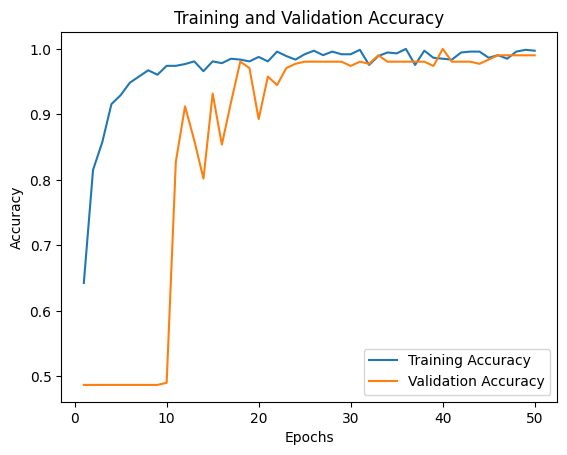

In [ ]:
import matplotlib.pyplot as plt
# Extract training and validation accuracy from history
train_accuracy_history = history.history['accuracy']
validation_accuracy_history = history.history['val_accuracy']

# Plot accuracy graph
epochs = range(1, len(train_accuracy_history) + 1)
plt.plot(epochs, train_accuracy_history, label='Training Accuracy')
plt.plot(epochs, validation_accuracy_history,label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



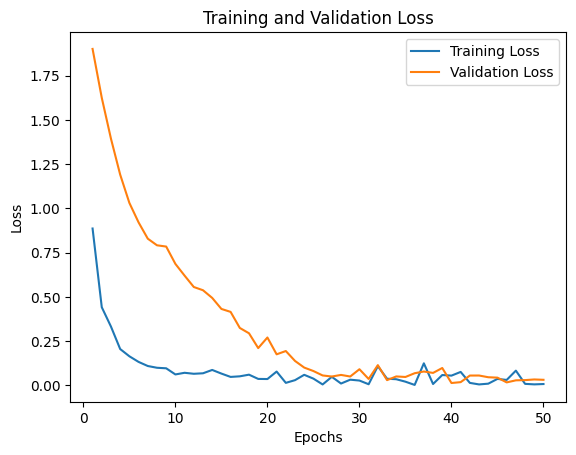

In [ ]:
train_loss_history = history.history['loss']
validation_loss_history = history.history['val_loss']

# Plot loss graph
epochs = range(1, len(train_loss_history) + 1)
plt.plot(epochs, train_loss_history,label='Training Loss')
plt.plot(epochs, validation_loss_history,label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


10/10 [==============================] - 0s 4ms/step


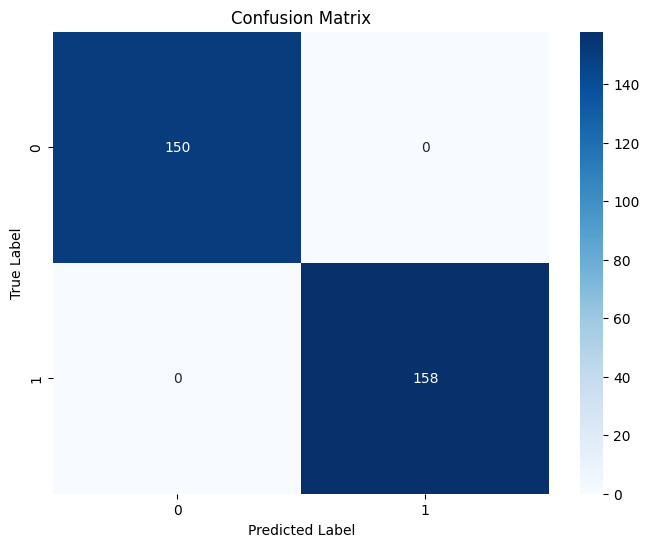

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Predict the classes on the test set
y_pred_prob = model.predict(x_test_scaled_reshaped)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import precision_score

# Assuming 'model' is your trained model and x_test_scaled_reshaped, y_test are your test data
y_pred_prob = model.predict(x_test_scaled_reshaped)
y_pred = np.argmax(y_pred_prob, axis=1)

precision = precision_score(y_test, y_pred, average='weighted')

print('Precision:', precision)


10/10 [==============================] - 0s 3ms/step
Precision: 1.0


In [ ]:
from sklearn.metrics import recall_score

# Assuming 'model' is your trained model and x_test_scaled_reshaped, y_test are your test data
y_pred_prob = model.predict(x_test_scaled_reshaped)
y_pred = np.argmax(y_pred_prob, axis=1)

recall = recall_score(y_test, y_pred, average='weighted')

print('Recall:', recall)


10/10 [==============================] - 0s 3ms/step
Recall: 1.0


In [ ]:
from sklearn.metrics import f1_score

# Assuming 'model' is your trained model and x_test_scaled_reshaped, y_test are your test data
y_pred_prob = model.predict(x_test_scaled_reshaped)
y_pred = np.argmax(y_pred_prob, axis=1)

f1 = f1_score(y_test, y_pred, average='weighted')

print('F1-score:', f1)



10/10 [==============================] - 0s 3ms/step
F1-score: 1.0
